## 1. Installing packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re

from sklearn import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split  # import 'train_test_split'
from sklearn.metrics import confusion_matrix, average_precision_score, classification_report
from sklearn.model_selection import cross_val_predict, train_test_split, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC
import xgboost as xgb
from catboost import CatBoostClassifier, Pool, cv
import optuna
from optuna.samplers import TPESampler
from collections import Counter

import skopt
from skopt.space import Integer
from skopt.space import Real
from skopt.space import Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from scipy.stats import boxcox 

from sklearn.decomposition import PCA
from plotly.offline import iplot
import plotly as py
import plotly.tools as tls

import pickle

#to display all rows and columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x) 

## 2. EDA (Explanatory of Data Analysis)
### Data description
- Age: age of the patient [years]
- Sex: sex of the patient [M: Male, F: Female]
- ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- RestingBP: resting blood pressure [mm Hg]
- Cholesterol: serum cholesterol [mm/dl]
- FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
- ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
- Oldpeak: oldpeak = ST [Numeric value measured in depression]
- ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- HeartDisease: output class [1: heart disease, 0: Normal]

### Data processing

In [2]:
url = 'https://raw.githubusercontent.com/minhvo2601/HeartFailurePrediction/master/heart.csv'
df = pd.read_csv(url)
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.00,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.00,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.00,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.50,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.00,Up,0


In [3]:
df.shape

(918, 12)

In [4]:
df.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [6]:
#Check null values 
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.00,53.51,9.43,28.00,47.00,54.00,60.00,77.00
RestingBP,918.00,132.40,18.51,0.00,120.00,130.00,140.00,200.00
Cholesterol,918.00,198.80,109.38,0.00,173.25,223.00,267.00,603.00
FastingBS,918.00,0.23,0.42,0.00,0.00,0.00,0.00,1.00
MaxHR,918.00,136.81,25.46,60.00,120.00,138.00,156.00,202.00
Oldpeak,918.00,0.89,1.07,-2.60,0.00,0.60,1.50,6.20
HeartDisease,918.00,0.55,0.50,0.00,0.00,1.00,1.00,1.00


In [8]:
df.describe(include=object).T

,count,unique,top,freq
Sex,918,2,M,725
ChestPainType,918,4,ASY,496
RestingECG,918,3,Normal,552
ExerciseAngina,918,2,N,547
ST_Slope,918,3,Flat,460


In [9]:
for col in df.select_dtypes(include=[np.number]).columns:
    print(f"{col} has {df[col].nunique()} unique value(s)")

Age has 50 unique value(s)
RestingBP has 67 unique value(s)
Cholesterol has 222 unique value(s)
FastingBS has 2 unique value(s)
MaxHR has 119 unique value(s)
Oldpeak has 53 unique value(s)
HeartDisease has 2 unique value(s)


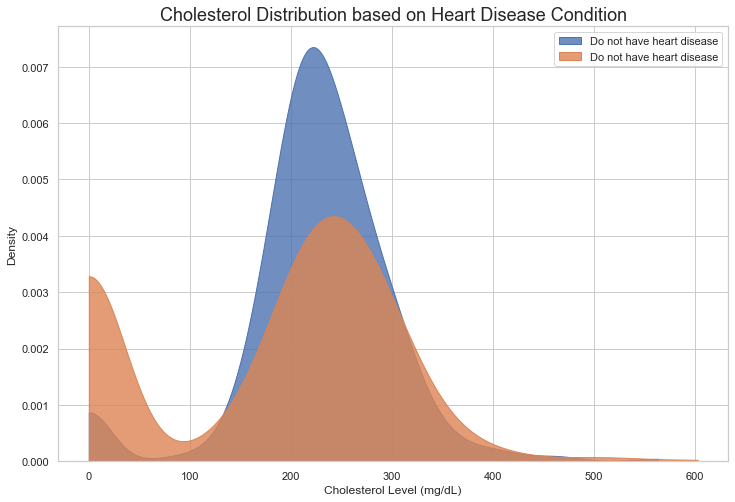

<Figure size 432x288 with 0 Axes>

In [38]:
#Analysis of cholesterol levels
sns.set_theme(style='whitegrid')
fig,ax = plt.subplots(figsize=(12,8))
sns.kdeplot(data = df[df['HeartDisease'] == 0], x='Cholesterol', label='Do not have heart disease', cut=0, fill=True, alpha=.8)
sns.kdeplot(data = df[df['HeartDisease'] == 1], x='Cholesterol', label='Do not have heart disease', cut=0, fill=True, alpha=.8)
plt.xlabel('Cholesterol Level (mg/dL)')
plt.ylabel('Density')
plt.title(label='Cholesterol Distribution based on Heart Disease Condition', fontsize=18)
plt.legend()
plt.show()
plt.savefig('cholesterol_dist.png')

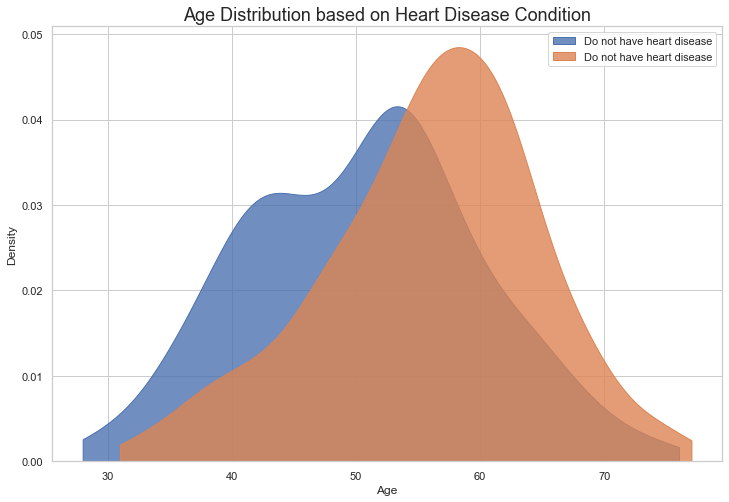

In [11]:
# Age distribution based on heart disease
sns.set_theme(style='whitegrid')
fig,ax = plt.subplots(figsize=(12,8))
sns.kdeplot(data = df[df['HeartDisease'] == 0], x='Age', label='Do not have heart disease', cut=0, fill=True, alpha=.8)
sns.kdeplot(data = df[df['HeartDisease'] == 1], x='Age', label='Do not have heart disease', cut=0, fill=True, alpha=.8)
plt.xlabel('Age')
plt.ylabel('Density')
plt.title(label='Age Distribution based on Heart Disease Condition', fontsize=18)
plt.legend()
plt.show()

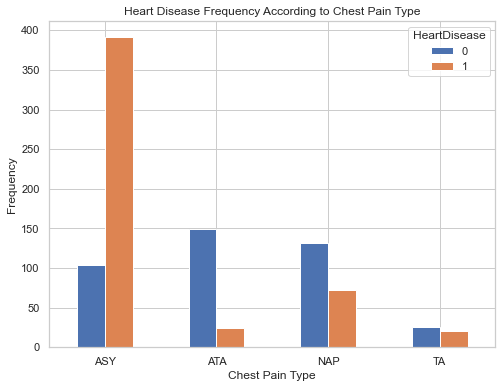

In [12]:
# Display chest pain types based on the target
pd.crosstab(df['ChestPainType'],df['HeartDisease']).plot(kind = "bar", figsize = (8, 6))
plt.title('Heart Disease Frequency According to Chest Pain Type')
plt.xlabel('Chest Pain Type')
plt.xticks(np.arange(4), rotation = 0)
plt.ylabel('Frequency')
plt.show()

<Figure size 1080x1080 with 0 Axes>

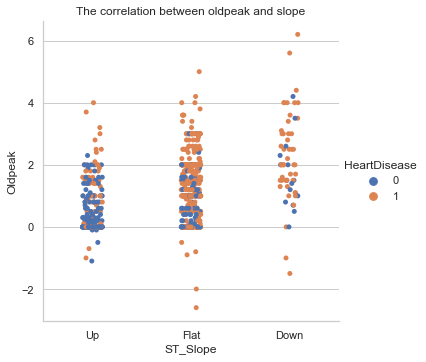

In [13]:
# Correlation between oldpeak, ST_slope and heart disease 
plt.figure(figsize=(15, 15))
sns.catplot(x = "ST_Slope", y = "Oldpeak", hue = "HeartDisease", data = df)
plt.title('The correlation between oldpeak and slope')
plt.xticks(np.arange(3), rotation = 0)
plt.show()

### Target variable ("HeartDisease") examination

In [14]:
#Percentage of patients who have and do not have heart disease
df['HeartDisease'].value_counts()

1    508
0    410
Name: HeartDisease, dtype: int64

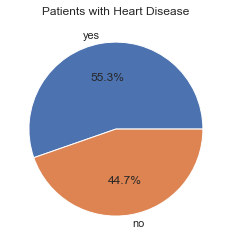

In [15]:
#Create a pie chart to display the percentage of patients with and without heart disease
labels = ['yes', 'no']
values = df['HeartDisease'].value_counts().values

plt.pie(values, labels = labels, autopct='%1.1f%%')
plt.title('Patients with Heart Disease')
plt.show()

In [16]:
df['HeartDisease'].describe()

count   918.00
mean      0.55
std       0.50
min       0.00
25%       0.00
50%       1.00
75%       1.00
max       1.00
Name: HeartDisease, dtype: float64

In [17]:
df[df['HeartDisease'] == 0].describe().T.style.background_gradient(cmap="YlGnBu")

,count,mean,std,min,25%,50%,75%,max
Age,410.000000,50.551220,9.444915,28.000000,43.000000,51.000000,57.000000,76.000000
RestingBP,410.000000,130.180488,16.499585,80.000000,120.000000,130.000000,140.000000,190.000000
Cholesterol,410.000000,227.121951,74.634659,0.000000,197.250000,227.000000,266.750000,564.000000
FastingBS,410.000000,0.107317,0.309894,0.000000,0.000000,0.000000,0.000000,1.000000
MaxHR,410.000000,148.151220,23.288067,69.000000,134.000000,150.000000,165.000000,202.000000
Oldpeak,410.000000,0.408049,0.699709,-1.100000,0.000000,0.000000,0.600000,4.200000
HeartDisease,410.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [18]:
df[df['HeartDisease'] == 1].describe().T.style.background_gradient(cmap="YlGnBu")

,count,mean,std,min,25%,50%,75%,max
Age,508.000000,55.899606,8.727056,31.000000,51.000000,57.000000,62.000000,77.000000
RestingBP,508.000000,134.185039,19.828685,0.000000,120.000000,132.000000,145.000000,200.000000
Cholesterol,508.000000,175.940945,126.391398,0.000000,0.000000,217.000000,267.000000,603.000000
FastingBS,508.000000,0.334646,0.472332,0.000000,0.000000,0.000000,1.000000,1.000000
MaxHR,508.000000,127.655512,23.386923,60.000000,112.000000,126.000000,144.250000,195.000000
Oldpeak,508.000000,1.274213,1.151872,-2.600000,0.000000,1.200000,2.000000,6.200000
HeartDisease,508.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Check feature importance

Text(0.5, 1.0, 'Correlation Plot')

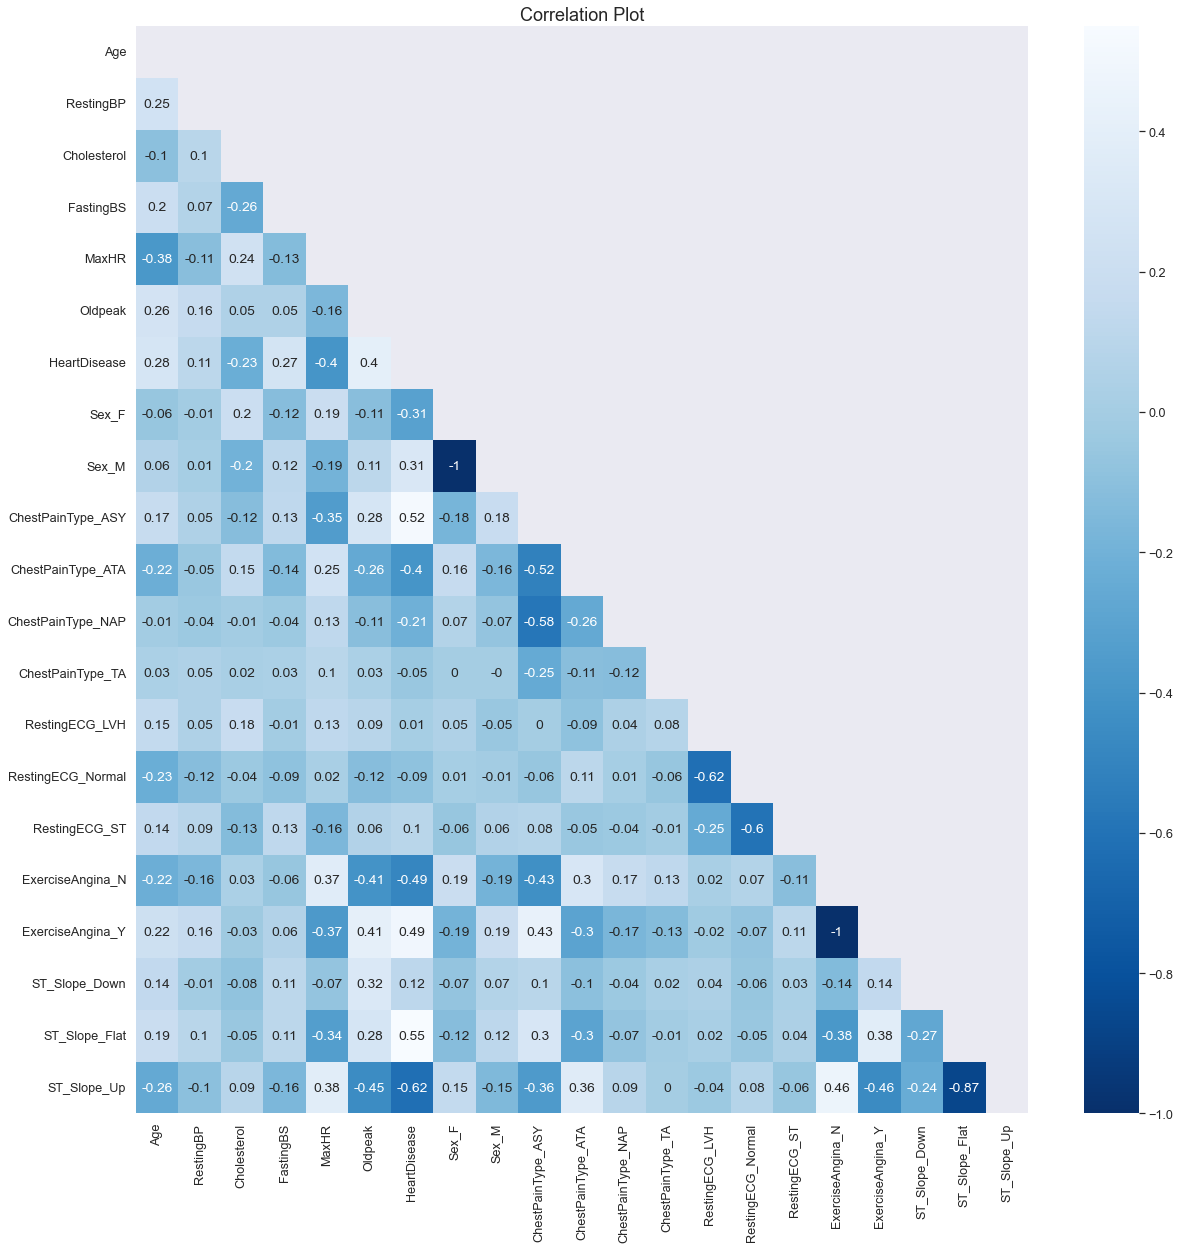

In [19]:
#Correlation map
df_heart = pd.get_dummies(df)
corr = df_heart.corr().round(2)
sns.set(font_scale=1.15)
plt.figure(figsize=(20,20))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,annot=True,cmap='Blues_r',mask=mask,cbar=True)
plt.title(label='Correlation Plot', fontsize=18)

<AxesSubplot:>

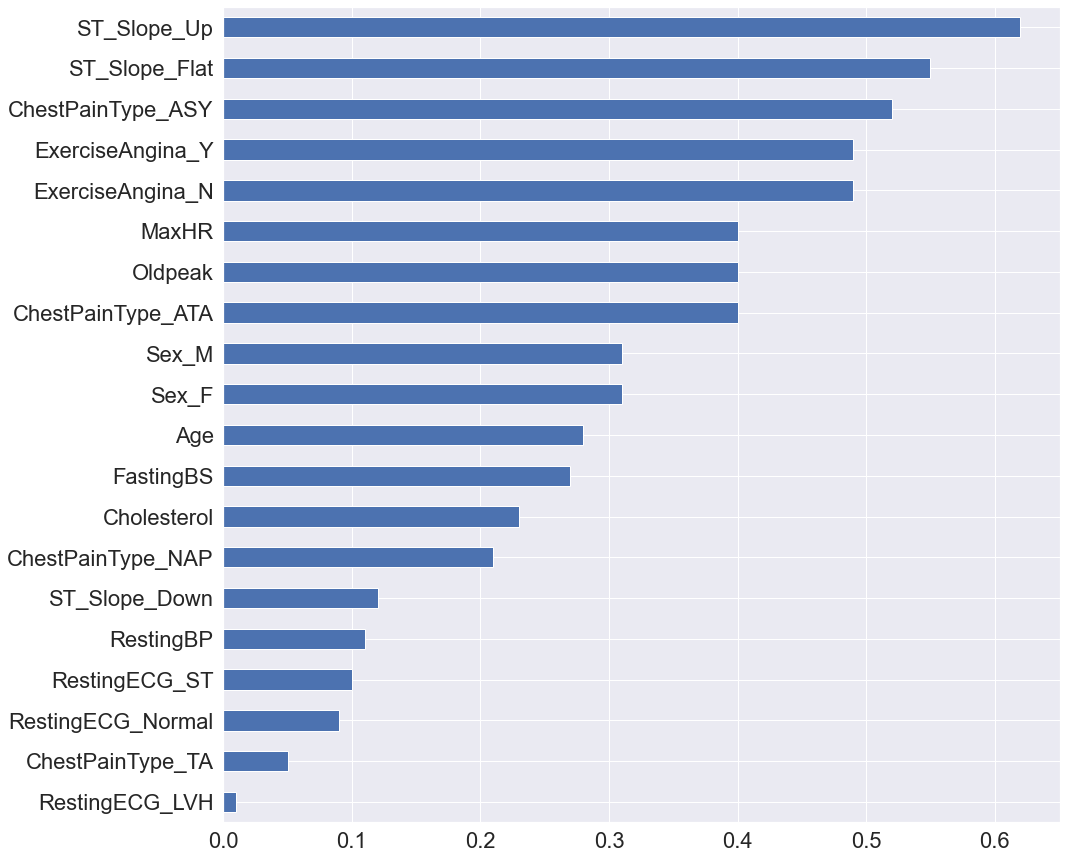

In [20]:
sns.set(font_scale=2)
plt.figure(figsize=(15, 15))
abs(corr['HeartDisease']).sort_values()[:-1].plot.barh()
plt.gca()

The heatmap shows the correlations between the dataset attributes, and how the attributes interact with each other. From the heatmap and the bar plots, we can see that the slope of the peak exercise ST segment, Chest pain type, and Oldpeak are highly correlated with the heart disease.

## 3. Data Modeling 


We will try the following machine learning algorithms to select the one with the highest accuracy based on its classification report


*   Logistic regression
*   Decision tree classifier
*   Random forest classifier
*   Gradient boost classifier
*   Support vector machine







In [21]:
from sklearn.preprocessing import LabelEncoder
ChestPainType_le = LabelEncoder()
RestingECG_le = LabelEncoder()
ExerciseAngina_le = LabelEncoder()
ST_Slope_le = LabelEncoder()
Sex_le = LabelEncoder()

In [22]:
df['ChestPainType'] = ChestPainType_le.fit_transform(df['ChestPainType'])
ChestPainType_le.classes_

array(['ASY', 'ATA', 'NAP', 'TA'], dtype=object)

In [23]:
df['RestingECG'] = RestingECG_le.fit_transform(df['RestingECG'])
RestingECG_le.classes_

array(['LVH', 'Normal', 'ST'], dtype=object)

In [24]:
df['ST_Slope'] = ST_Slope_le.fit_transform(df['ExerciseAngina'])
ST_Slope_le.classes_

array(['N', 'Y'], dtype=object)

In [25]:
df['ExerciseAngina'] = ExerciseAngina_le.fit_transform(df['ExerciseAngina'])
ExerciseAngina_le.classes_

array(['N', 'Y'], dtype=object)

In [26]:
df['Sex'] = Sex_le.fit_transform(df['Sex'])
Sex_le.classes_

array(['F', 'M'], dtype=object)

In [27]:
#train, test = train_test_split(df,test_size=0.2,random_state= 1234)
X = df.drop('HeartDisease', axis=1)
y = df.HeartDisease
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=21)

In [28]:
X.shape

(918, 11)

In [29]:
y.shape

(918,)

In [30]:
#train=pd.get_dummies(train)
#test=pd.get_dummies(test)
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
std_scaler.fit(X)
X_train_std=std_scaler.transform(X_train)
X_test_std=std_scaler.transform(X_test)

X_train = pd.DataFrame(X_train_std, columns=X.columns)
X_test = pd.DataFrame(X_test_std, columns=X.columns)

In [31]:
#logistic regresion
lr = LogisticRegression(C = 80)
model1 = lr.fit(X_train, y_train)
print("train accuracy: ", model1.score(X_train, y_train))
print("test accuracy:: ", model1.score(X_test, y_test))
lrpredict = lr.predict(X_test)
print("classification report for logistic regression")
print(classification_report(lrpredict, y_test))

train accuracy:  0.8147138964577657
test accuracy::  0.8478260869565217
classification report for logistic regression
              precision    recall  f1-score   support

           0       0.87      0.79      0.82        84
           1       0.83      0.90      0.87       100

    accuracy                           0.85       184
   macro avg       0.85      0.84      0.85       184
weighted avg       0.85      0.85      0.85       184



In [32]:
#decision tree classifier
dt = DecisionTreeClassifier()
model2 = dt.fit(X_train, y_train)
print("train accuracy: ", model1.score(X_train, y_train))
print("test accuracy:: ", model1.score(X_test, y_test))
dtpredict = dt.predict(X_test)
print("classification report for decision tree classifier")
print(classification_report(dtpredict, y_test))

train accuracy:  0.8147138964577657
test accuracy::  0.8478260869565217
classification report for decision tree classifier
              precision    recall  f1-score   support

           0       0.68      0.69      0.69        75
           1       0.79      0.78      0.78       109

    accuracy                           0.74       184
   macro avg       0.74      0.74      0.74       184
weighted avg       0.75      0.74      0.74       184



In [33]:
#random forest classifier
rf = RandomForestClassifier()
model3 = rf.fit(X_train, y_train)
print("train accuracy: ", model3.score(X_train, y_train))
print("test accuracy:: ", model3.score(X_test, y_test))
rfpredict = rf.predict(X_test)
print("classification report for random forest classifier")
print(classification_report(rfpredict, y_test))

train accuracy:  1.0
test accuracy::  0.8260869565217391
classification report for random forest classifier
              precision    recall  f1-score   support

           0       0.84      0.76      0.80        84
           1       0.81      0.88      0.85       100

    accuracy                           0.83       184
   macro avg       0.83      0.82      0.82       184
weighted avg       0.83      0.83      0.83       184



In [34]:
# gradient boost classifier 
gbm = GradientBoostingClassifier()
model4 = gbm.fit(X_train, y_train)
print("train accuracy: ", model4.score(X_train, y_train))
print("test accuracy:: ", model4.score(X_test, y_test))
gbmpredict = gbm.predict(X_test)
print("classification report for gradient boost classifier")
print(classification_report(gbmpredict, y_test))

train accuracy:  0.9168937329700273
test accuracy::  0.8152173913043478
classification report for gradient boost classifier
              precision    recall  f1-score   support

           0       0.82      0.76      0.78        82
           1       0.81      0.86      0.84       102

    accuracy                           0.82       184
   macro avg       0.82      0.81      0.81       184
weighted avg       0.82      0.82      0.81       184



In [35]:
# support vector machine
svc = SVC()
model5 = svc.fit(X_train, y_train)
print("train accuracy: ", model5.score(X_train, y_train))
print("test accuracy:: ", model5.score(X_test, y_test))
svcpredict = svc.predict(X_test)
print("classification report for support vector machine")
print(classification_report(svcpredict, y_test))

train accuracy:  0.8678474114441417
test accuracy::  0.8586956521739131
classification report for support vector machine
              precision    recall  f1-score   support

           0       0.91      0.78      0.84        88
           1       0.82      0.93      0.87        96

    accuracy                           0.86       184
   macro avg       0.87      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184



In [36]:
# Save the model as serialized object pickle 
with open('model.pkl', 'wb') as file:
  pickle.dump(svc, file)